Примеры задач:

- ранжировать документы по степени релевантности заданной теме (тематический поиск);
- ранжировать документы по степени тематического сходства с заданным документом или его фрагментом;
- построить иерархический тематический каталог коллекции документов и выработать правила каталогизации новых документов;
- определить, как темы изменялись со временем (предполагается, что для каждого документа известно время его создания);
- определить тематику авторов (предполагается, что для каждого документа известен список авторов);
- определить тематику различных сущностей (entities), связанных с документами (например, журналов, конференций, организаций, стран);
- разбить документ на тематически однородные фрагменты.


[источник](http://www.machinelearning.ru/wiki/index.php?title=%D0%A2%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5)

библиотеки:
- pyLDAvis
- matplotlib
- numpy
- pandas
- gensim
- nltk
- bigARTM


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import pickle
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
lemma = WordNetLemmatizer()

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

D:\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


[nltk_data] Downloading package wordnet to
[nltk_data]     D:\Anaconda3\lib\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     D:\Anaconda3\lib\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Пример анализ тем в статьях NIPS

## https://www.kaggle.com/benhamner/nips-papers

In [3]:
df = pd.read_csv('nips-papers/papers.csv')

In [4]:
print(df.shape)
df.head(10)

(7241, 7)


,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."
5,1002,1994,Using a neural net to instantiate a deformable...,NaN,1002-using-a-neural-net-to-instantiate-a-defor...,Abstract Missing,U sing a neural net to instantiate a\ndeformab...
6,1003,1994,Plasticity-Mediated Competitive Learning,NaN,1003-plasticity-mediated-competitive-learning.pdf,Abstract Missing,Plasticity-Mediated Competitive Learning\n\nTe...
7,1004,1994,ICEG Morphology Classification using an Analog...,NaN,1004-iceg-morphology-classification-using-an-a...,Abstract Missing,ICEG Morphology Classification using an\nAnalo...
8,1005,1994,Real-Time Control of a Tokamak Plasma Using Ne...,NaN,1005-real-time-control-of-a-tokamak-plasma-usi...,Abstract Missing,Real-Time Control of a Tokamak Plasma\nUsing N...
9,1006,1994,Pulsestream Synapses with Non-Volatile Analogu...,NaN,1006-pulsestream-synapses-with-non-volatile-an...,Abstract Missing,Real-Time Control of a Tokamak Plasma\nUsing N...


In [5]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words = set(stop_words)

In [6]:
def clean(text):
    # Remove new line characters
    text = re.sub('\s+', ' ', text)
    # Remove distracting single quotes
    text = re.sub("\'", "", text)
    return text


def doc_to_words(doc, stop_words, lemma):
    stop_words = set(stop_words)
    # remove stop words and punctuation
    words = [w for w in gensim.utils.simple_preprocess(str(doc), deacc=True) if w not in stop_words]
    
    # make lemmatization
    words = [lemma.lemmatize(w) for w in words]
    
    return words

In [7]:
prepare = True

In [8]:
%%time
if prepare:
    # Convert to list
    data = df.paper_text.values.tolist()

    data = [clean(t) for t in data]
    data_words = [doc_to_words(t, stop_words, lemma) for t in data]
    
    with open('data.pkl', 'wb') as f:
        pickle.dump({'data': data, 'data_words': data_words}, f)
else:
    with open('data.pkl', 'rb') as f:
        d = pickle.load(f)
        data = d['data']
        data_words = d['data_words']

pprint(data_words[0][:40])

['self',
 'organization',
 'associative',
 'database',
 'application',
 'hisashi',
 'suzuki',
 'suguru',
 'arimoto',
 'osaka',
 'university',
 'toyonaka',
 'osaka',
 'japan',
 'abstract',
 'efficient',
 'method',
 'self',
 'organizing',
 'associative',
 'database',
 'proposed',
 'together',
 'application',
 'robot',
 'eyesight',
 'system',
 'proposed',
 'database',
 'associate',
 'input',
 'output',
 'first',
 'half',
 'part',
 'discussion',
 'algorithm',
 'self',
 'organization',
 'proposed']
Wall time: 2min 22s


In [9]:
%%time
if prepare:
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    bigram_mod.save('bigram_mod.pkl')
    
    data_words_bigrams = [bigram_mod[w] for w in data_words]
    with open('bigrams.pkl', 'wb') as f:
        pickle.dump(data_words_bigrams, f)

else:
    bigram_mod = gensim.models.Phrases.load('bigram_mod.pkl')
    
    with open('bigrams.pkl', 'rb') as f:
        data_words_bigrams = pickle.load(f)

Wall time: 1min 48s


In [10]:
data_words_bigrams[0][:10]

['self_organization',
 'associative',
 'database',
 'application',
 'hisashi',
 'suzuki',
 'suguru',
 'arimoto',
 'osaka',
 'university']

In [11]:
%%time
if prepare:
    id2word = corpora.Dictionary(data_words_bigrams)
    id2word.save('id2word.pkl')
else:
    id2word = corpora.Dictionary.load('id2word.pkl')

Wall time: 9.05 s


In [12]:
%%time
corpus = [id2word.doc2bow(text) for text in data_words_bigrams]

Wall time: 6.74 s


In [13]:
corpus[0][:10]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 2),
 (4, 1),
 (5, 6),
 (6, 1),
 (7, 1),
 (8, 3),
 (9, 1)]

In [14]:
id2word[8]

'actual'

In [15]:
data[0]

'767 SELF-ORGANIZATION OF ASSOCIATIVE DATABASE AND ITS APPLICATIONS Hisashi Suzuki and Suguru Arimoto Osaka University, Toyonaka, Osaka 560, Japan ABSTRACT An efficient method of self-organizing associative databases is proposed together with applications to robot eyesight systems. The proposed databases can associate any input with some output. In the first half part of discussion, an algorithm of self-organization is proposed. From an aspect of hardware, it produces a new style of neural network. In the latter half part, an applicability to handwritten letter recognition and that to an autonomous mobile robot system are demonstrated. INTRODUCTION Let a mapping f : X -+ Y be given. Here, X is a finite or infinite set, and Y is another finite or infinite set. A learning machine observes any set of pairs (x, y) sampled randomly from X x Y. (X x Y means the Cartesian product of X and Y.) And, it computes some estimate j : X -+ Y of f to make small, the estimation error in some measure. U

In [16]:
data[0].count('accordingly')

6

In [17]:
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 2),
 (4, 1),
 (5, 6),
 (6, 1),
 (7, 1),
 (8, 3),
 (9, 1),
 (10, 2),
 (11, 2),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 2),
 (16, 8),
 (17, 1),
 (18, 1),
 (19, 2),
 (20, 2),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 6),
 (28, 2),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 5),
 (33, 3),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 1),
 (38, 2),
 (39, 7),
 (40, 1),
 (41, 1),
 (42, 3),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 1),
 (47, 1),
 (48, 1),
 (49, 1),
 (50, 13),
 (51, 1),
 (52, 3),
 (53, 1),
 (54, 1),
 (55, 1),
 (56, 2),
 (57, 2),
 (58, 1),
 (59, 1),
 (60, 3),
 (61, 1),
 (62, 4),
 (63, 2),
 (64, 2),
 (65, 1),
 (66, 1),
 (67, 2),
 (68, 2),
 (69, 4),
 (70, 1),
 (71, 3),
 (72, 1),
 (73, 3),
 (74, 9),
 (75, 1),
 (76, 2),
 (77, 6),
 (78, 1),
 (79, 1),
 (80, 1),
 (81, 1),
 (82, 1),
 (83, 1),
 (84, 2),
 (85, 1),
 (86, 1),
 (87, 2),
 (88, 1),
 (89, 11),
 (90, 4),
 (91, 1),
 (92, 1),
 (93, 1),
 (94, 7),
 (95, 1),
 (96, 1),
 (97, 1),
 (98, 1),
 (99, 4),
 (100, 1

In [18]:
%%time
if prepare:
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=20, 
        random_state=100,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True)
    lda_model.save('lda_default.pkl')
else:
    lda_model = gensim.models.ldamodel.LdaModel.load('lda_default.pkl')

Wall time: 15min 49s


In [19]:
pprint(lda_model.print_topics())

[(0,
  '0.024*"signal" + 0.021*"system" + 0.018*"time" + 0.016*"control" + '
  '0.014*"source" + 0.012*"trajectory" + 0.012*"target" + 0.009*"noise" + '
  '0.009*"dynamic" + 0.008*"figure"'),
 (1,
  '0.012*"arxiv_preprint" + 0.006*"st" + 0.006*"kx" + 0.005*"long_beach" + '
  '0.005*"eq" + 0.005*"respectively" + 0.005*"th" + 0.004*"al" + 0.004*"ii" + '
  '0.004*"following"'),
 (2,
  '0.023*"point" + 0.012*"solution" + 0.011*"function" + 0.009*"one" + '
  '0.009*"case" + 0.009*"equation" + 0.008*"value" + 0.008*"problem" + '
  '0.008*"local" + 0.008*"constraint"'),
 (3,
  '0.069*"image" + 0.020*"object" + 0.014*"convolutional" + 0.011*"pixel" + '
  '0.010*"model" + 0.009*"map" + 0.008*"visual" + 0.008*"recognition" + '
  '0.008*"using" + 0.008*"frame"'),
 (4,
  '0.032*"algorithm" + 0.022*"problem" + 0.019*"optimization" + 0.017*"method" '
  '+ 0.017*"function" + 0.013*"gradient" + 0.012*"loss" + 0.011*"convex" + '
  '0.011*"learning" + 0.010*"objective"'),
 (5,
  '0.012*"set" + 0.010*"nu

In [20]:
%%time
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

Wall time: 1min 18s


In [21]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8     -0.120662 -0.030539       1        1  9.901420
9     -0.143073 -0.139894       2        1  9.693207
18    -0.091293 -0.036891       3        1  9.282038
4     -0.151050 -0.130116       4        1  7.850171
5     -0.113537  0.010938       5        1  7.405191
17    -0.032112  0.072763       6        1  5.800398
6     -0.081619  0.058355       7        1  4.932710
2     -0.029949 -0.130875       8        1  4.771500
14    -0.064717  0.001131       9        1  4.701760
12    -0.087943 -0.101212      10        1  4.528399
16    -0.060511 -0.047960      11        1  4.353325
10     0.079563  0.137192      12        1  4.249203
3      0.018616  0.097128      13        1  3.928748
13    -0.019873  0.109349      14        1  3.803671
11     0.110054  0.111422      15        1  3.077863
7      0.080305  0.112499      16        1  2.679866
19     0.074397  0.033499      17        1  2.635397
1      0.351457 -0.342394      18        1  2.319097
0      0.164097  0.141810      19        1  2.284995
15     0.117851  0.073794      20        1  1.801040, topic_info=            Term           Freq          Total Category  logprob  loglift
451        model  155714.000000  155714.000000  Default  30.0000  30.0000
470      network   78634.000000   78634.000000  Default  29.0000  29.0000
346        image   45252.000000   45252.000000  Default  28.0000  28.0000
1038      matrix   51044.000000   51044.000000  Default  27.0000  27.0000
275      feature   40977.000000   40977.000000  Default  26.0000  26.0000
...          ...            ...            ...      ...      ...      ...
552   processing    1539.368845   22084.170362  Topic20  -5.2588   1.3533
471       neural    1608.109940   51518.644100  Topic20  -5.2151   0.5499
483       number    1400.532536   51301.545467  Topic20  -5.3533   0.4159
1208       using    1231.964153   64673.971414  Topic20  -5.4816   0.0561
2199      scheme    1158.506101    7628.929127  Topic20  -5.5430   2.1320

[1478 rows x 6 columns], token_table=       Topic      Freq                  Term
term                                        
59239      3  0.998267       aaron_courville
99599      7  0.998436  absolute_discounting
5289       4  0.977905           accelerated
5289       5  0.006955           accelerated
5289      20  0.014606           accelerated
...      ...       ...                   ...
8857       3  0.247895                    zt
8857       4  0.158054                    zt
8857       9  0.025372                    zt
8857      17  0.560676                    zt
8857      18  0.007487                    zt

[4758 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 10, 19, 5, 6, 18, 7, 3, 15, 13, 17, 11, 4, 14, 12, 8, 20, 2, 1, 16])

In [32]:
%%time
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.151159268746868

Coherence Score:  0.4549351316322289


In [23]:
%%time
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.15115919231209

Coherence Score:  0.4549351316322289


In [24]:
lda_model.get_document_topics(corpus[22])

[(2, 0.04503143),
 (4, 0.14354584),
 (5, 0.05435283),
 (6, 0.010055193),
 (7, 0.016024968),
 (8, 0.11549007),
 (9, 0.049557358),
 (14, 0.4621343),
 (17, 0.07067498)]

In [25]:
data[22]

'Generalization in Reinforcement Learning: Safely Approximating the Value Function Justin A. Boyan and Andrew W. Moore Computer Science Department Carnegie Mellon University Pittsburgh, PA 15213 jab@cs.cmu.edu, awm@cs.cmu .edu Abstract A straightforward approach to the curse of dimensionality in reinforcement learning and dynamic programming is to replace the lookup table with a generalizing function approximator such as a neural net. Although this has been successful in the domain of backgammon, there is no guarantee of convergence. In this paper, we show that the combination of dynamic programming and function approximation is not robust, and in even very benign cases, may produce an entirely wrong policy. We then introduce Grow-Support, a new algorithm which is safe from divergence yet can still reap the benefits of successful generalization . 1 INTRODUCTION Reinforcement learning-the problem of getting an agent to learn to act from sparse, delayed rewards-has been advanced by techn

In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics, 
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=40, step=6)

Wall time: 2h 1min 43s


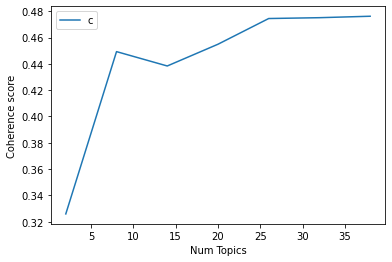

In [28]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [143]:
if prepare:
    lda_model_opt = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=8, 
        random_state=100,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True)
    lda_model_opt.save('lda_opt.pkl')
else:
    lda_model_opt = gensim.models.ldamodel.LdaModel.load('lda_opt.pkl')

In [77]:
pprint(lda_model_opt.print_topics())

[(0,
  '0.013*"model" + 0.012*"neuron" + 0.009*"time" + 0.008*"cell" + '
  '0.007*"neural" + 0.007*"figure" + 0.007*"signal" + 0.007*"system" + '
  '0.007*"response" + 0.006*"activity"'),
 (1,
  '0.014*"algorithm" + 0.013*"graph" + 0.012*"node" + 0.009*"set" + '
  '0.008*"time" + 0.008*"cluster" + 0.007*"clustering" + 0.007*"structure" + '
  '0.007*"number" + 0.006*"tree"'),
 (2,
  '0.050*"network" + 0.022*"neural" + 0.017*"input" + 0.015*"learning" + '
  '0.015*"layer" + 0.013*"output" + 0.012*"weight" + 0.012*"training" + '
  '0.012*"unit" + 0.008*"function"'),
 (3,
  '0.032*"image" + 0.012*"object" + 0.012*"model" + 0.011*"feature" + '
  '0.007*"using" + 0.007*"convolutional" + 0.006*"representation" + '
  '0.006*"map" + 0.006*"method" + 0.006*"recognition"'),
 (4,
  '0.016*"algorithm" + 0.012*"function" + 0.010*"problem" + 0.008*"bound" + '
  '0.008*"matrix" + 0.008*"method" + 0.007*"theorem" + 0.006*"learning" + '
  '0.006*"result" + 0.006*"log"'),
 (5,
  '0.031*"model" + 0.018*"d

In [185]:
doc_rl1 = '''Deep reinforcement learning on Atari games maps pixel directly to actions; internally,
the deep neural network bears the responsibility of both extracting useful
information and making decisions based on it. Aiming at devoting entire deep
networks to decision making alone, we propose a new method for learning policies
and compact state representations separately but simultaneously for policy
approximation in reinforcement learning. State representations are generated by a
novel algorithm based on Vector Quantization and Sparse Coding, trained online
along with the network, and capable of growing its dictionary size over time. We
also introduce new techniques allowing both the neural network and the evolution
strategy to cope with varying dimensions. This enables networks of only 6 to 18
neurons to learn to play a selection of Atari games with performance comparable—
and occasionally superior—to state-of-the-art techniques using evolution strategies
on deep networks two orders of magnitude larger.'''


doc_rl2 = '''Deep reinforcement learning methods traditionally struggle with tasks where environment
rewards are particularly sparse. One successful method of guiding
exploration in these domains is to imitate trajectories provided by a human demonstrator.
However, these demonstrations are typically collected under artificial
conditions, i.e. with access to the agent’s exact environment setup and the demonstrator’s
action and reward trajectories. Here we propose a two-stage method that
overcomes these limitations by relying on noisy, unaligned footage without access
to such data. First, we learn to map unaligned videos from multiple sources to a
common representation using self-supervised objectives constructed over both time
and modality (i.e. vision and sound). Second, we embed a single YouTube video
in this representation to construct a reward function that encourages an agent to
imitate human gameplay. This method of one-shot imitation allows our agent to
convincingly exceed human-level performance on the infamously hard exploration
games MONTEZUMA’S REVENGE, PITFALL! and PRIVATE EYE for the first time†
,
even if the agent is not presented with any environment rewards.
'''

doc_cv = '''Convolutional Neural Networks (CNNs) have become the method of choice 
for learning problems involving 2D planar images. However, a number of problems of recent 
interest have created a demand for models that can analyze spherical images. 
Examples include omnidirectional vision for drones, robots, and autonomous cars, 
molecular regression problems, and global weather and climate modelling. 
A naive application of convolutional networks to a planar projection of the spherical signal
is destined to fail, because the space-varying distortions introduced by such a projection will
make translational weight sharing ineffective.
In this paper we introduce the building blocks for constructing spherical CNNs. 
We propose a definition for the spherical cross-correlation that is both expressive and rotation-equivariant.
The spherical correlation satisfies a generalized Fourier theorem, which allows us to compute 
it efficiently using a generalized (non-commutative) Fast Fourier Transform (FFT) algorithm.
We demonstrate the computational efficiency, numerical accuracy, and effectiveness of spherical 
CNNs applied to 3D model recognition and atomization energy regression.
'''

In [152]:
def doc2bowl_bigram(doc):
    doc = clean(doc)
    words = doc_to_words(doc, stop_words, lemma)
    bigrams = bigram_mod[words]
    bow = id2word.doc2bow(bigrams)
    return bow, bigrams

In [186]:
bow_rl1, bigrams_rl1 = doc2bowl_bigram(doc_rl1)
bow_rl2, bigrams_rl2 = doc2bowl_bigram(doc_rl2)
bow_cv, bigrams_cv = doc2bowl_bigram(doc_cv)

In [187]:
bigrams_rl1

['deep',
 'reinforcement',
 'learning',
 'atari_game',
 'map',
 'pixel',
 'directly',
 'action',
 'internally',
 'deep',
 'neural',
 'network',
 'bear',
 'responsibility',
 'extracting',
 'useful',
 'information',
 'making',
 'decision',
 'based',
 'aiming',
 'devoting',
 'entire',
 'deep',
 'network',
 'decision',
 'making',
 'alone',
 'propose',
 'new',
 'method',
 'learning',
 'policy',
 'compact',
 'state',
 'representation',
 'separately',
 'simultaneously',
 'policy',
 'approximation',
 'reinforcement',
 'learning',
 'state',
 'representation',
 'generated',
 'novel',
 'algorithm',
 'based',
 'vector',
 'quantization',
 'sparse',
 'coding',
 'trained',
 'online',
 'along',
 'network',
 'capable',
 'growing',
 'dictionary',
 'size',
 'time',
 'also',
 'introduce',
 'new',
 'technique',
 'allowing',
 'neural',
 'network',
 'evolution',
 'strategy',
 'cope',
 'varying',
 'dimension',
 'enables',
 'network',
 'neuron',
 'learn',
 'play',
 'selection',
 'atari_game',
 'performance',
 

In [189]:
lda_model_opt.get_document_topics(bow_rl1)

[(2, 0.3263107),
 (3, 0.2581074),
 (4, 0.017848648),
 (6, 0.026870906),
 (7, 0.34916314)]

In [190]:
lda_model_opt.get_document_topics(bow_rl2)

[(3, 0.29723138),
 (4, 0.015419452),
 (5, 0.03982899),
 (6, 0.11953734),
 (7, 0.50085264)]

In [191]:
lda_model_opt.get_document_topics(bow_cv)

[(0, 0.029139243),
 (1, 0.11906097),
 (2, 0.077320196),
 (3, 0.44559783),
 (4, 0.16184708),
 (5, 0.11535659),
 (7, 0.043800566)]

In [192]:
def bow2feat(bow):
    return np.asarray([x for _, x in lda_model.get_document_topics(bow, minimum_probability=0)])


def doc2feat(doc):
    bow, _ = doc2bowl_bigram(doc)
    return bow2feat(bow)

In [194]:
feat_rl1 = doc2feat(doc_rl1)
feat_rl2 = doc2feat(doc_rl2)
feat_cv = doc2feat(doc_cv)

In [198]:
print(feat_rl1.shape)
feat_rl1

(20,)


array([0.00347409, 0.00494003, 0.01583711, 0.04266278, 0.01496889,
       0.01671956, 0.0161709 , 0.00446689, 0.03555086, 0.00768752,
       0.00424144, 0.02585269, 0.02773212, 0.12899452, 0.28083357,
       0.02106646, 0.00525921, 0.29093683, 0.02459397, 0.02801055],
      dtype=float32)

In [195]:
from scipy.spatial import distance
from itertools import combinations

In [196]:
names = ['rl1', 'rl2', 'cv']
feats = [feat_rl1, feat_rl2, feat_cv]
names_feat = zip(names, feats)

for (n1, f1), (n2, f2) in combinations(names_feat, 2):
    print('doc1: {}, doc2: {}, similarity {:.2f}'.format(n1, n2, distance.euclidean(f1, f2)))

doc1: rl1, doc2: rl2, similarity 0.27
doc1: rl1, doc2: cv, similarity 0.48
doc1: rl2, doc2: cv, similarity 0.48


# Russian example

https://github.com/maxoodf/russian_news_corpus

```bash
git clone https://github.com/maxoodf/russian_news_corpus.git
cd ./russian_news_corpus
cat ./russian_news.txt.bz2_a* | bzip2 -d > ./russian_news.txt
cat russian_news.txt | awk 'BEGIN {srand()} !/^$/ { if (rand() <= .005) print $0}' > russian_news_10k.txt
```

In [199]:
stop_words = set(stopwords.words('russian'))

In [208]:
from pathlib import Path

In [241]:
data_ru = Path('/media/storage/data_nlp/russian_news_corpus/russian_news_10k.txt').read_text(encoding='utf-8').split('\n')

In [242]:
def doc_to_words_ru(doc, stop_words):
    stop_words = set(stop_words)
    # remove stop words and punctuation
    words = [w for w in gensim.utils.simple_preprocess(str(doc), deacc=True, max_len=100) if w not in stop_words]
    
    return words

In [ ]:
prepare = False

In [243]:
data_ru = [clean(t) for t in data_ru]
data_words_ru = [doc_to_words_ru(t, stop_words) for t in data_ru]

In [244]:
data_words_ru[0][:10]

['сми',
 'называть',
 'украина',
 'коррумпированныи',
 'болото',
 'мир',
 'политика',
 'аргумент',
 'факт',
 'москва']

In [245]:
# Build the bigram and trigram models
bigram_ru = gensim.models.Phrases(data_words_ru, min_count=5, threshold=100) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod_ru = gensim.models.phrases.Phraser(bigram_ru)
    
data_words_bigrams_ru = [bigram_mod_ru[w] for w in data_words_ru]

In [246]:
data_words_bigrams_ru[1][:10]

['цивилизованныи',
 'подход',
 'наркоз',
 'город',
 'новость',
 'санкт_петербург',
 'фонтанка_ру',
 'приморскии',
 'раион',
 'петербург']

In [247]:
id2word_ru = corpora.Dictionary(data_words_bigrams_ru)
corpus_ru = [id2word_ru.doc2bow(text) for text in data_words_bigrams_ru]

In [248]:
lda_model_ru = gensim.models.ldamodel.LdaModel(
    corpus=corpus_ru,
    id2word=id2word_ru,
    num_topics=20, 
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True)

In [249]:
pprint(lda_model_ru.print_topics())

[(0,
  '0.021*"человек" + 0.020*"москва" + 0.019*"сообщать" + 0.011*"место" + '
  '0.011*"происходить" + 0.009*"улица" + 0.009*"здание" + 0.008*"находиться" + '
  '0.008*"мужчина" + 0.008*"погибать"'),
 (1,
  '0.027*"сбербанк" + 0.015*"минфин" + 0.015*"снижаться" + 0.011*"магазин" + '
  '0.010*"продукт" + 0.010*"ставка" + 0.009*"мост" + 0.008*"валюта" + '
  '0.008*"реитинг" + 0.008*"выпуск"'),
 (2,
  '0.034*"крым" + 0.025*"интернет" + 0.023*"депутат" + 0.019*"закон" + '
  '0.016*"госдума" + 0.012*"законопроект" + 0.008*"депутат_госдума" + '
  '0.007*"лнр" + 0.007*"нилов" + 0.007*"сеть"'),
 (3,
  '0.015*"сирия" + 0.014*"военныи" + 0.014*"оон" + 0.011*"город" + '
  '0.010*"посол" + 0.010*"сша" + 0.009*"сила" + 0.009*"нато" + '
  '0.008*"россиискии" + 0.008*"россия"'),
 (4,
  '0.022*"суд" + 0.020*"дело" + 0.019*"год" + 0.009*"сотрудник" + '
  '0.009*"задерживать" + 0.009*"сообщать" + 0.008*"которыи" + 0.008*"бывшии" + '
  '0.006*"убииство" + 0.006*"экс"'),
 (5,
  '0.008*"роман" + 0.008*"и

In [250]:
with open('lda_ru', 'wb') as f:
    pickle.dump({
        "data_ru": data_ru,
        "data_words_ru": data_words_ru,
        "bigram_mod_ru": bigram_mod_ru,
        "data_words_bigrams_ru": data_words_bigrams_ru,
        "id2word_ru": id2word_ru,
        "corpus_ru": corpus_ru,
        "lda_model_ru": lda_model_ru,
    }, f)

In [295]:
model_list_ru, coherence_values_ru = compute_coherence_values(
    dictionary=id2word_ru, corpus=corpus_ru, texts=data_words_bigrams_ru, start=2, limit=40, step=6)

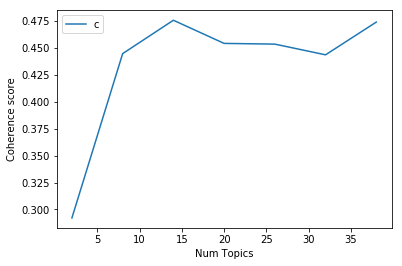

In [297]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_ru)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [301]:
lda_model_opt_ru = model_list_ru[2]
lda_model_opt_ru.save('lda_model_opt_ru.pkl')

In [300]:
lda_model_opt_ru.print_topics()

[(0,
  '0.023*"человек" + 0.015*"москва" + 0.013*"сообщать" + 0.010*"место" + 0.010*"город" + 0.010*"происходить" + 0.008*"дом" + 0.008*"улица" + 0.007*"здание" + 0.007*"данные"'),
 (1,
  '0.039*"год" + 0.025*"банк" + 0.014*"рубль" + 0.012*"составлять" + 0.012*"компания" + 0.011*"рынок" + 0.009*"рост" + 0.009*"млн" + 0.009*"цена" + 0.008*"млрд"'),
 (2,
  '0.015*"крым" + 0.009*"новыи" + 0.009*"ребенок" + 0.007*"завод" + 0.007*"интернет" + 0.007*"работа" + 0.007*"специалист" + 0.007*"ученыи" + 0.006*"школа" + 0.006*"год"'),
 (3,
  '0.025*"суд" + 0.023*"дело" + 0.012*"год" + 0.012*"задерживать" + 0.009*"сотрудник" + 0.008*"убииство" + 0.008*"которыи" + 0.007*"полиция" + 0.007*"бывшии" + 0.006*"мвд"'),
 (4,
  '0.022*"год" + 0.019*"сообщать" + 0.015*"москва" + 0.015*"россия" + 0.013*"риа_новость" + 0.012*"россиискии" + 0.011*"март" + 0.009*"новость" + 0.008*"тасс" + 0.006*"проходить"'),
 (5,
  '0.012*"аукцион" + 0.012*"грузия" + 0.010*"чечня" + 0.009*"дипломат" + 0.007*"месторождение" + 0.0